In [16]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ee.Initialize(project='ee-urbanfootprint')
warsaw = ee.Geometry.Point([21.0122, 52.2297]).buffer(25_000)  # 25km buffer


In [2]:
EMB = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
CLC2018 = ee.Image("COPERNICUS/CORINE/V20/100m/2018").select("landcover")

print("Datasets loaded")


Datasets loaded


In [5]:
def corine_urban_mask(aoi):
    clc = CLC2018.clip(aoi)
    # Artificial surfaces = 1xx (100-199)
    urban = clc.gte(100).And(clc.lt(200)).rename("urban").toByte()
    return urban

urban2018 = corine_urban_mask(warsaw)

# Quick sanity check
urban_sum = urban2018.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=warsaw,
    scale=100,
    maxPixels=1e13
).get("urban")

print("CORINE urban pixels (sum):", ee.Number(urban_sum).getInfo())


CORINE urban pixels (sum): 74410.78823529415


In [3]:
def emb_year(year, aoi):
    col = (EMB
           .filterDate(f"{year}-01-01", f"{year+1}-01-01")
           .filterBounds(aoi))
    
    # median reduces seams vs mosaic
    return col.mosaic().clip(aoi)


In [4]:
K = 20

emb2018 = emb_year(2018, warsaw)

# sampling at 100m matches CORINE resolution better
samples = emb2018.sample(
    region=warsaw,
    scale=100,
    numPixels=12000,
    seed=42,
    geometries=False
)

clusterer = ee.Clusterer.wekaKMeans(K).train(samples)

print("KMeans trained with K =", K)


KMeans trained with K = 20


In [6]:
def cluster_map(year):
    emb = emb_year(year, warsaw)
    return emb.cluster(clusterer).rename("cluster")

def cluster_urban_score(cluster_img, urban_mask, aoi):
    stacked = urban_mask.rename("urban").addBands(cluster_img.rename("cluster"))

    stats = stacked.reduceRegion(
        reducer=ee.Reducer.mean().group(groupField=1, groupName="cluster"),
        geometry=aoi,
        scale=100,
        maxPixels=1e13
    )

    groups = ee.List(stats.get("groups")).getInfo()

    out = {}
    for g in groups:
        out[int(g["cluster"])] = float(g["mean"])
    return out

cl2018 = cluster_map(2018)
urban_scores = cluster_urban_score(cl2018, urban2018, warsaw)

urban_scores


{0: 0.14043668122270742,
 1: 0.39952761149601856,
 2: 0.6743104800370328,
 3: 0.021553713419876604,
 4: 0.9935634520881785,
 5: 0.10627733715760217,
 6: 0.022122001930292866,
 7: 0.020134196538789898,
 8: 0.8919385170912361,
 9: 0.5359954201776165,
 10: 0.09954577255142959,
 11: 0.12290980690636533,
 12: 0.04156606229323178,
 13: 0.05131275844195563,
 14: 0.7964857477262373,
 15: 0.9522947848805241,
 16: 0.39669062576738773,
 17: 0.02148072738743454,
 18: 0.1437067875494337,
 19: 0.9735074583604826}

In [7]:
sorted_scores = sorted(urban_scores.items(), key=lambda x: x[1], reverse=True)
print("Top urban clusters:", sorted_scores[:5])
print("Top non-urban clusters:", sorted_scores[-5:])


Top urban clusters: [(4, 0.9935634520881785), (19, 0.9735074583604826), (15, 0.9522947848805241), (8, 0.8919385170912361), (14, 0.7964857477262373)]
Top non-urban clusters: [(12, 0.04156606229323178), (6, 0.022122001930292866), (3, 0.021553713419876604), (17, 0.02148072738743454), (7, 0.020134196538789898)]


In [8]:
cl2018 = cluster_map(2018)

m = geemap.Map()
m.centerObject(warsaw, 9)

# random-ish palette for clusters 
palette = [
    "1f77b4","ff7f0e","2ca02c","d62728","9467bd",
    "8c564b","e377c2","7f7f7f","bcbd22","17becf",
    "aec7e8","ffbb78","98df8a","ff9896","c5b0d5",
    "c49c94","f7b6d2","c7c7c7","dbdb8d","9edae5",
    "393b79","637939","8c6d31","843c39","7b4173",
    "5254a3","6b6ecf","9c9ede","cedb9c","e7cb94"
]

m.addLayer(
    cl2018,
    {"min": 0, "max": K-1, "palette": palette[:K]},
    f"KMeans clusters (2018) K={K}"
)

m.addLayer(warsaw, {}, "ROI")
m

Map(center=[52.229725646962365, 21.012201161188926], controls=(WidgetControl(options=['position', 'transparent…

In [9]:
URBAN_T = 0.79
NONURBAN_T = 0.04

urban_clusters = [c for c, s in urban_scores.items() if s >= URBAN_T]
nonurban_clusters = [c for c, s in urban_scores.items() if s <= NONURBAN_T]

print("Urban clusters:", urban_clusters)
print("Non-urban clusters:", nonurban_clusters)


Urban clusters: [4, 8, 14, 15, 19]
Non-urban clusters: [3, 6, 7, 17]


In [10]:
def three_class_from_clusters(cluster_img):
    urban = cluster_img.remap(urban_clusters, [1]*len(urban_clusters), 0)
    nonurban = cluster_img.remap(nonurban_clusters, [1]*len(nonurban_clusters), 0)

    uncertain = urban.Not().And(nonurban.Not())
    cls = nonurban.multiply(0).add(uncertain.multiply(1)).add(urban.multiply(2)).rename("cls")
    return cls


In [11]:
def area_km2(mask, aoi, scale=100):
    pix_area_km2 = ee.Image.pixelArea().divide(1e6)
    area_img = pix_area_km2.updateMask(mask)
    s = area_img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=scale,
        maxPixels=1e13
    )
    return float(s.get("area").getInfo()) if s.get("area") else 0.0


years = list(range(2018, 2025))  # 2018..2024
rows = []

for y in years:
    cl = cluster_map(y)
    cls = three_class_from_clusters(cl)

    urban_mask = cls.eq(2).rename("area")
    urban_km2 = area_km2(urban_mask, warsaw, scale=100)

    rows.append({"year": y, "urban_km2": urban_km2})

df = pd.DataFrame(rows)
df


,year,urban_km2
0,2018,557.412151
1,2019,606.270886
2,2020,638.079856
3,2021,614.391409
4,2022,621.689441
5,2023,697.663002
6,2024,638.085992


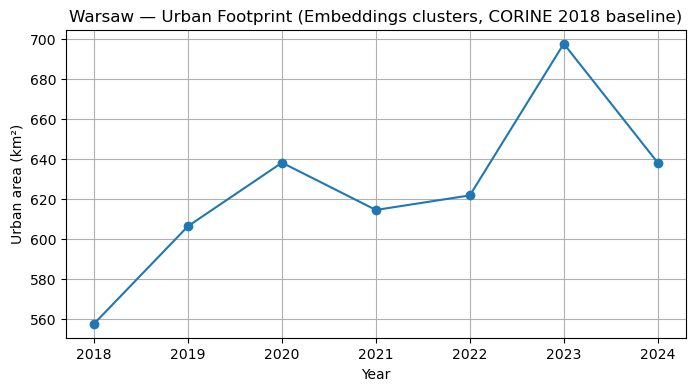

In [12]:
plt.figure(figsize=(8,4))
plt.plot(df["year"], df["urban_km2"], marker="o")
plt.xlabel("Year")
plt.ylabel("Urban area (km²)")
plt.title("Warsaw — Urban Footprint (Embeddings clusters, CORINE 2018 baseline)")
plt.grid(True)
plt.show()


In [13]:
cls_2018 = three_class_from_clusters(cluster_map(2018))
cls_2024 = three_class_from_clusters(cluster_map(2024))

urban18 = cls_2018.eq(2)
urban24 = cls_2024.eq(2)

uncertain = cls_2018.eq(1).Or(cls_2024.eq(1))
gain = urban18.Not().And(urban24)
loss = urban18.And(urban24.Not())

# 0=no change, 1=gain, 2=loss, 3=uncertain
change = (gain.multiply(1)
          .add(loss.multiply(2))
          .add(uncertain.multiply(3))).rename("change")

print("Change map ready")


Change map ready


In [14]:
m = geemap.Map()
m.centerObject(warsaw, 9)

change_vis = {"min": 0, "max": 3,
              "palette": ["000000", "00ff00", "ff0000", "ffff00"]}

palette_3class = ["0000ff", "aaaaaa", "ff0000"]  # nonurban / uncertain / urban

m.addLayer(cls_2018, {"min":0, "max":2, "palette":palette_3class}, "3-class 2018")
m.addLayer(cls_2024, {"min":0, "max":2, "palette":palette_3class}, "3-class 2024")
m.addLayer(change, change_vis, "Change 2018→2024 (gain/loss/uncertain)")
m


Map(center=[52.22972564696269, 21.012201161188944], controls=(WidgetControl(options=['position', 'transparent_…

In [17]:
pred2018 = three_class_from_clusters(cluster_map(2018)).eq(2).rename("pred")
gt2018 = urban2018.rename("gt")

val = pred2018.addBands(gt2018).sample(
    region=warsaw, scale=100, numPixels=5000, seed=0, geometries=False
)

pred = np.array(val.aggregate_array("pred").getInfo())
gt   = np.array(val.aggregate_array("gt").getInfo())

TP = np.sum((pred==1) & (gt==1))
FP = np.sum((pred==1) & (gt==0))
FN = np.sum((pred==0) & (gt==1))

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)
f1        = 2*precision*recall/(precision+recall+1e-9)

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)


Precision: 0.7588495575212845
Recall: 0.36941303177147583
F1: 0.49692140484714853


In [18]:
df["delta_km2"] = df["urban_km2"].diff()
df["pct_change"] = 100 * df["delta_km2"] / df["urban_km2"].shift(1)
df


,year,urban_km2,delta_km2,pct_change
0,2018,557.412151,NaN,NaN
1,2019,606.270886,48.858736,8.765280
2,2020,638.079856,31.808970,5.246660
3,2021,614.391409,-23.688447,-3.712458
4,2022,621.689441,7.298032,1.187847
5,2023,697.663002,75.973562,12.220501
6,2024,638.085992,-59.577010,-8.539511


In [19]:
total_gain = df["urban_km2"].iloc[-1] - df["urban_km2"].iloc[0]
print("Total urban increase 2018→2024 (km²):", total_gain)


Total urban increase 2018→2024 (km²): 80.67384163933036


In [20]:
def flip_rate(y0, y1):
    c0 = cluster_map(y0)
    c1 = cluster_map(y1)
    # where cluster changed
    changed = c0.neq(c1).rename("changed")
    # compute fraction changed (mean of changed mask)
    frac = changed.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=warsaw,
        scale=100,
        maxPixels=1e13
    ).get("changed").getInfo()
    return frac

for y in range(2018, 2024):
    print(y, "→", y+1, "flip rate:", flip_rate(y, y+1))


2018 → 2019 flip rate: 0.1747691341396976
2019 → 2020 flip rate: 0.1661005904032357
2020 → 2021 flip rate: 0.20513772161554336
2021 → 2022 flip rate: 0.15643961837199372
2022 → 2023 flip rate: 0.1962262252262135
2023 → 2024 flip rate: 0.17754825949260553


In [21]:
years = list(range(2018, 2025))  # 2018..2024
clusters = [cluster_map(y) for y in years]

# count how many times cluster label changes year-to-year
flip_imgs = []
for i in range(len(clusters) - 1):
    flip_imgs.append(clusters[i].neq(clusters[i+1]).rename("flip"))

instability = ee.ImageCollection(flip_imgs).sum().rename("n_flips")


In [22]:
m = geemap.Map()
m.centerObject(warsaw, 9)

vis = {
    "min": 0,
    "max": 6,
    "palette": ["1a1a1a", "ffffb2", "fecc5c", "fd8d3c", "f03b20", "bd0026"]
}

m.addLayer(instability, vis, "Embedding instability (2018–2024)")
m


Map(center=[52.229725646962365, 21.012201161188926], controls=(WidgetControl(options=['position', 'transparent…